In [1]:
from lime_implementation import create_explainer_wine, create_explainer_cifar, create_explain_pipeline, visualize_lime_img

C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import argparse

import numpy as np
import matplotlib.pyplot as plt
import jax
from flax.linen import relu
from flax.linen.initializers import kaiming_uniform

from data_loaders import load_cifar10, load_wine_quality
from models import Cifar10CNN, WineQualityNetwork, create_model, load_weights
from utils import validate_cifar, validate_wine

#random number generator key (seed)
rng = jax.random.PRNGKey(0)

#create data folder
datapath = './data'
os.makedirs(datapath, exist_ok=True)

#download datasets and store the splits
cif_train, cif_val, cif_test = load_cifar10(datapath)
wine_train, wine_val, wine_test = load_wine_quality(datapath)

#load models
cifar_model, _ = create_model(Cifar10CNN, rng, init_func=kaiming_uniform(), activation_func=relu)
wine_model, _ = create_model(WineQualityNetwork, rng, input_shape=(1, 11), init_func=kaiming_uniform(), activation_func=relu)

#create weight dictionary
weights = {
    'cifar' : {
        0 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/initial_weights.pkl'),
        1 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/best_weights.pkl'),
        2 : load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/overtrained_model.pkl')
                },
    'wine' : {
        0 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/initial_weights.pkl'),
        1 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/best_weights.pkl'),
        2 : load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/overtrained_model.pkl')
                }
}

In [3]:
wine_explainer, wine_data, wine_labels = create_explainer_wine(wine_test)

In [4]:
cifar_explainer, cifar_data, cifar_labels = create_explainer_cifar(cif_test)

In [5]:
explain_cifar_sample = create_explain_pipeline(cifar_explainer, cifar_model, weights['cifar'][1])
explain_wine_sample = create_explain_pipeline(wine_explainer, wine_model, weights['wine'][1])

In [6]:
wine_explanations = [explain_wine_sample(wine_data[i]) for i in range(10)]

C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
C:\Users\marlo\anaconda3\envs\blackbox_lime\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
 

[None, None, None, None, None, None, None, None, None, None]

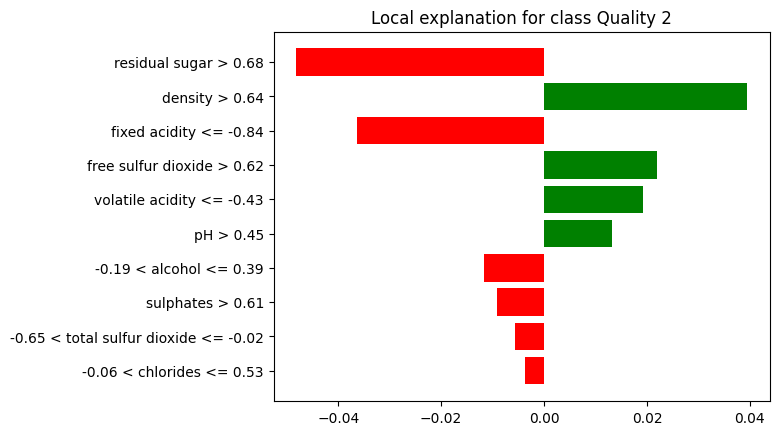

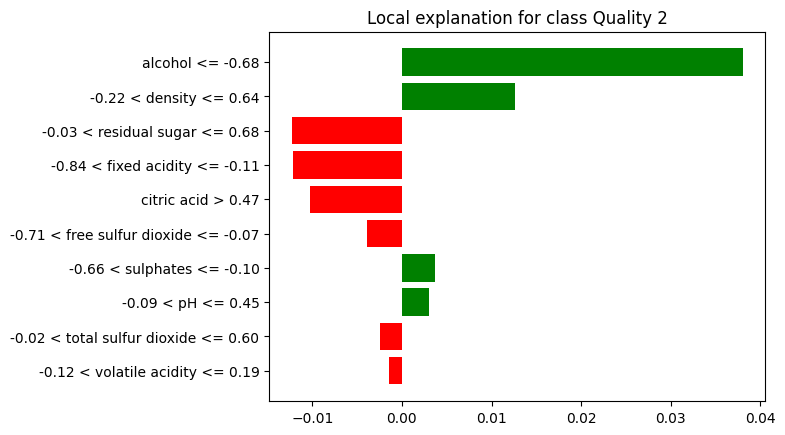

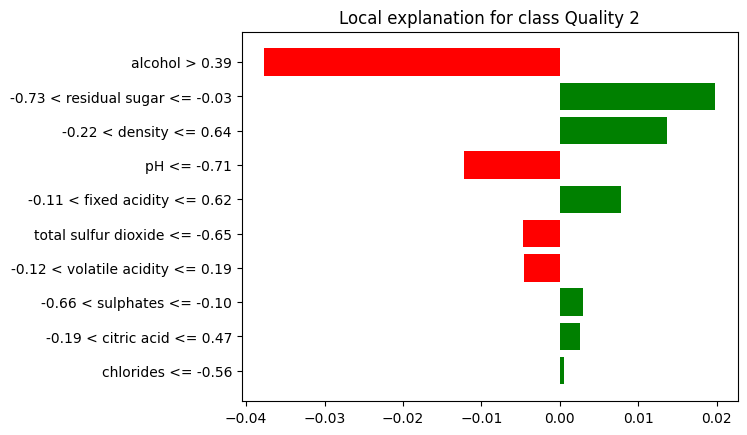

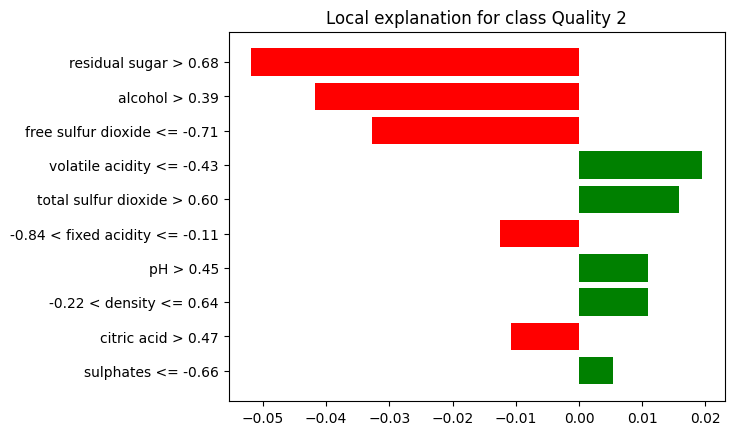

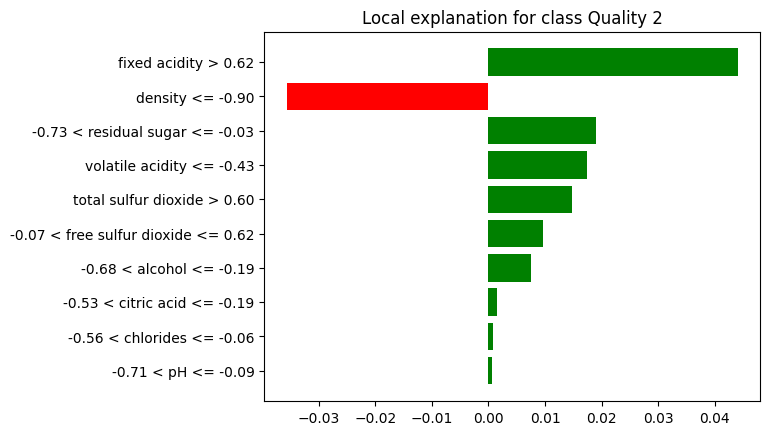

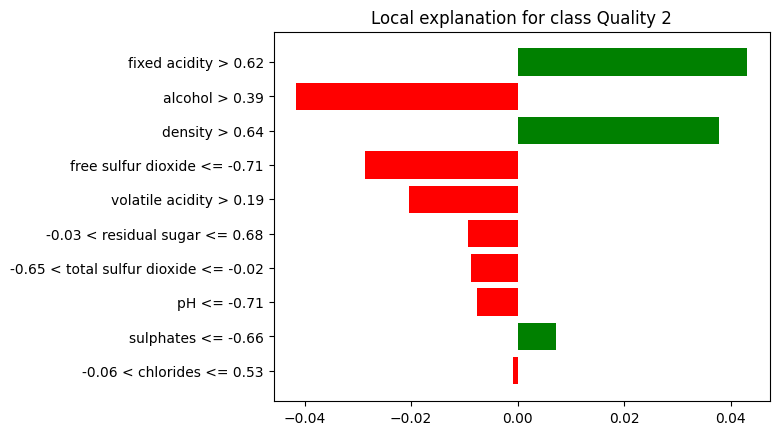

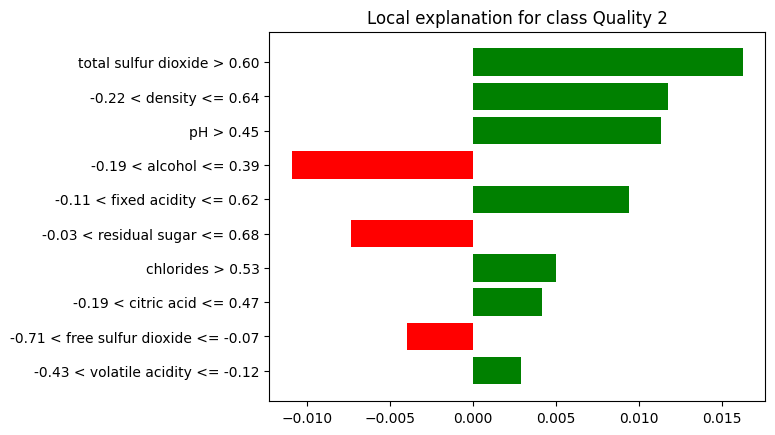

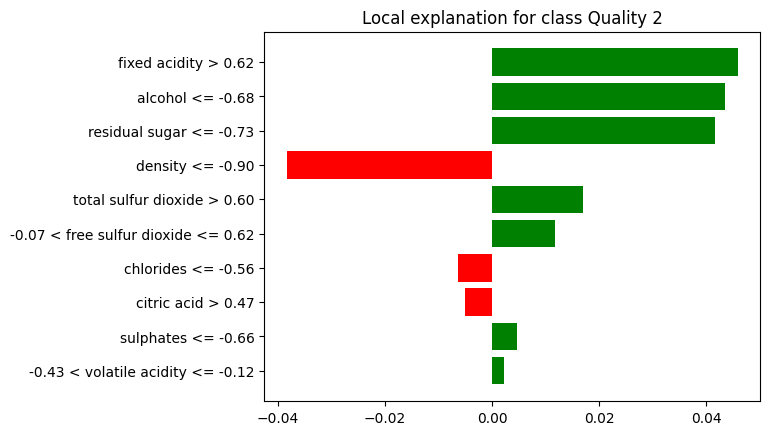

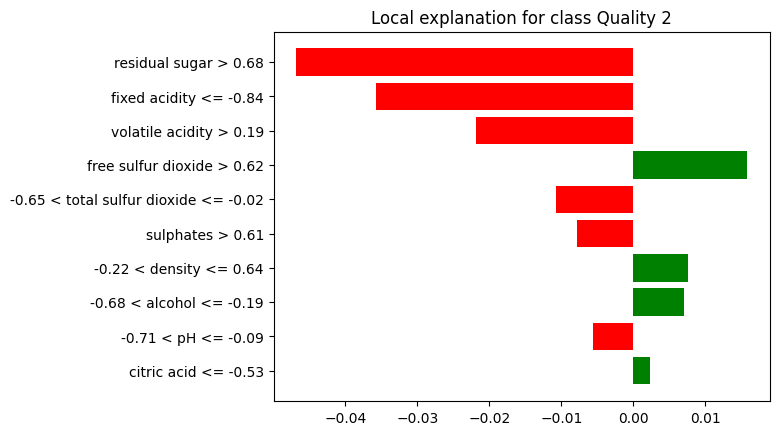

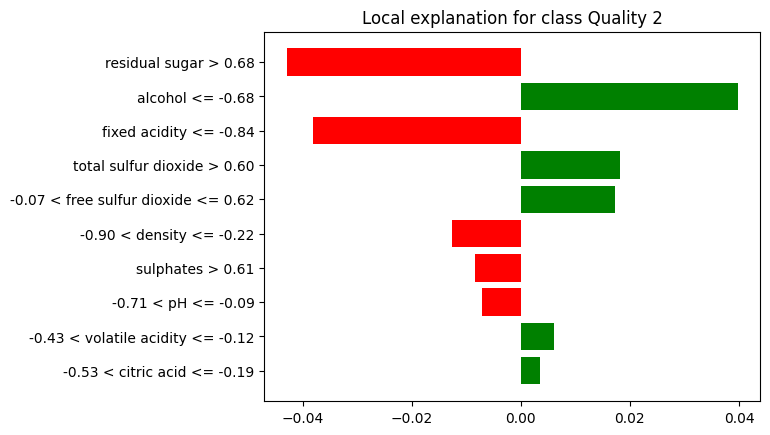

In [7]:
[exp.as_pyplot_figure().savefig(f'./img/wine_explanation_{i}.jpg') for i, exp in enumerate(wine_explanations)]

In [8]:
cifar_explanations = [explain_cifar_sample(cifar_data[i]) for i in range(10)]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 660.85it/s]


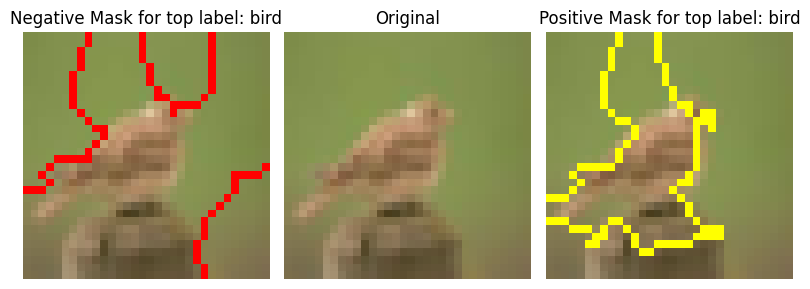

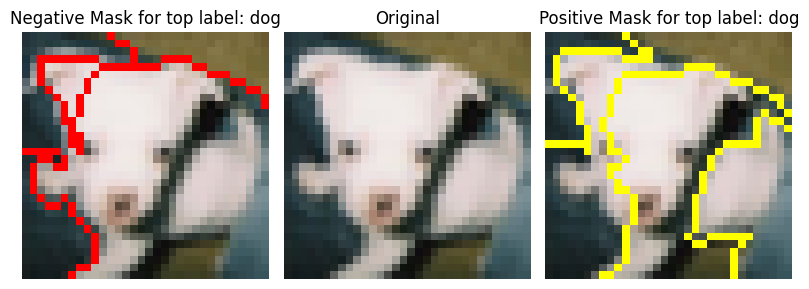

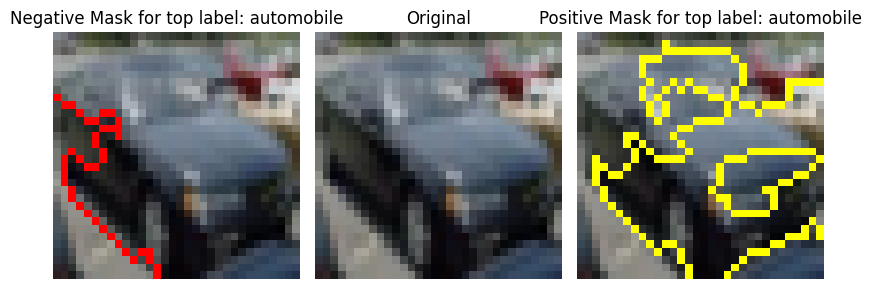

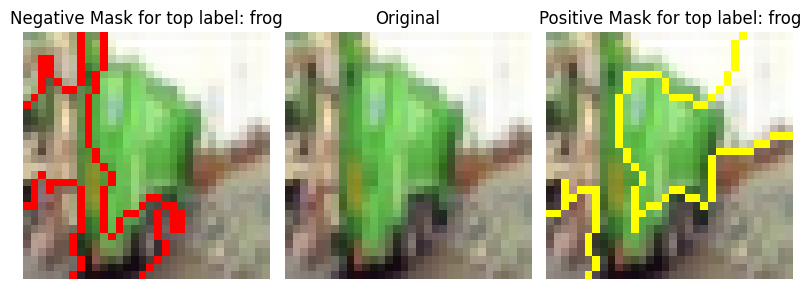

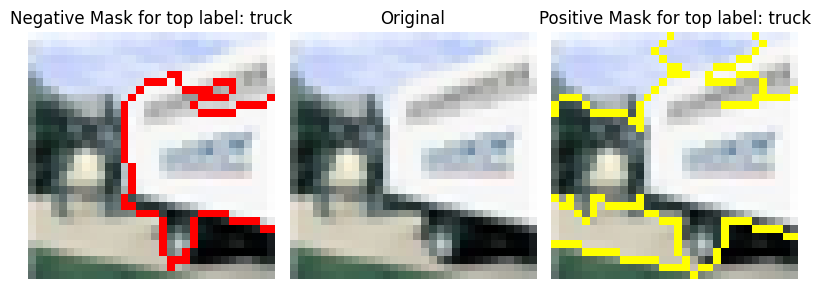

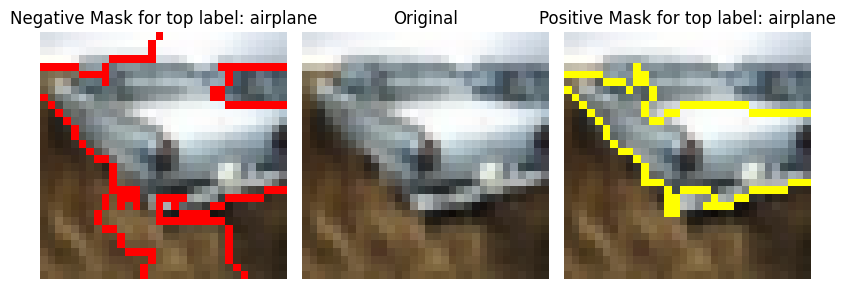

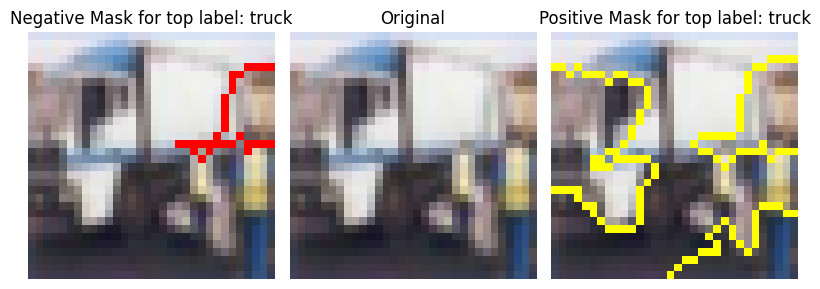

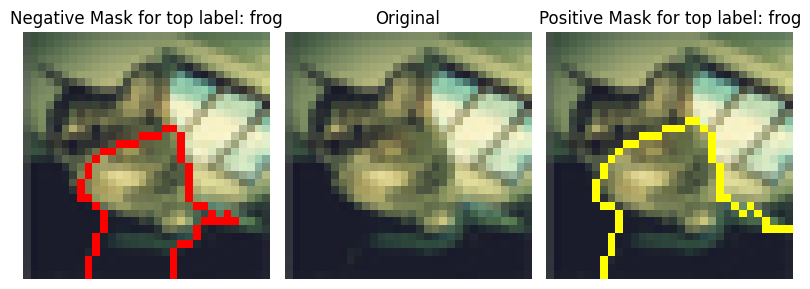

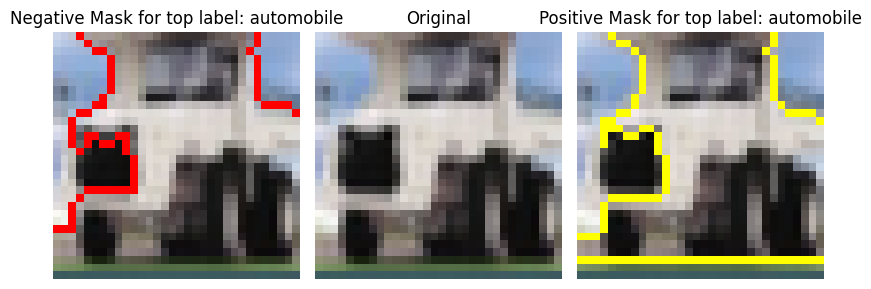

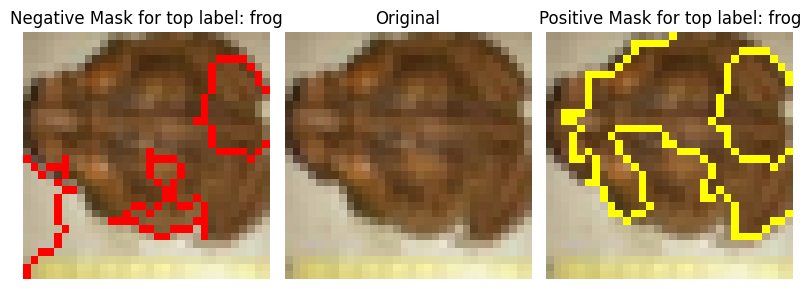

In [9]:
for i, epx in enumerate(cifar_explanations):
    top_label = cifar_explanations[i].top_labels[0]

    original_img = cifar_data[i]
    _, pos_mask = cifar_explanations[i].get_image_and_mask(top_label, positive_only=True, hide_rest=True)
    _, neg_mask = cifar_explanations[i].get_image_and_mask(top_label, positive_only=False, negative_only=True, hide_rest=True)
    
    visualize_lime_img(original_img, neg_mask, pos_mask, top_label=top_label, output_path=f'./img/cifar_sample{i}_explanation.jpg')